# Matrix Methods for PageRank: Theoretical Foundations and Computational Applications

This notebook provides a computational study of the PageRank algorithm. By simulating small web graphs and progressively modifying their structure through the addition of pages with controlled link patterns, we investigate how such changes influence the PageRank vector and alter the resulting ranking of pages.

The notebook provides reproducible Python implementations, including:

- a modular routine to generate $\mathbf{M}$ and the initial vector $\mathbf{v}_0$ from any given link matrix $\mathbf{A}$.

- a power method for efficiently computing the PageRank vector.

- interactive plots that illustrate the impact of varying the damping factor $m$.


**Reference:** K. Bryan, T. L. Leise, *The \$25,000,000,000 Eigenvector: The Linear Algebra behind Google*, SIAM Review, 2006.  

---

## Exercise 11
Consider again the web in Figure 2.1, with the addition of a page 5 that links to page 3, where page 3 also links to page 5. Calculate the new ranking by finding the eigenvector of $\mathbf{M}$ (corresponding to $\lambda=1$) that has positive components summing to one. Use $m=0.15$.

---

### Libraries Import and Functions Definitions

In [38]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, FloatSlider, fixed
import ipywidgets as widgets
import networkx as nx
from scipy.sparse import issparse, csr_matrix


def compute_M_matrix(A, m):
    n = A.shape[0]
    S = np.ones((n, n)) / n
    if issparse(A):
        S_sparse = csr_matrix(S)
        M = (1 - m) * A + m * S_sparse
    else:
        M = (1 - m) * A + m * S
    v0 = np.ones(n)
    v0 /= np.linalg.norm(v0, 2)
    return M, v0

def pagerank_power_method_classic(M, v, max_iter=1000, tol=1e-10):
    lam_old = None
    lambdas = []
    errors = []

    v = np.asarray(v).reshape(-1)  

    for _ in range(max_iter):
        w = M @ v
        w = np.asarray(w).reshape(-1)
        lam = float(np.dot(v, w))
        lambdas.append(lam)
        v = w / np.linalg.norm(w, 2)
        if lam_old is None:
            errors.append(np.nan)
        else:
            error = abs(lam - lam_old)
            errors.append(error)
            if error < tol * abs(lam):
                break
        lam_old = lam
    v_fin = v / v.sum()
    return v_fin, np.array(lambdas), np.array(errors)

### 4-Pages Web PageRank Computation

In [39]:
A4 = np.array([
    [0,   0,   1/2, 1/2],
    [1/3, 0,   0,   0],
    [1/3, 1/2, 0,   1/2],
    [1/3, 1/2, 0,   0]
])

def plot_pagerank_classic(m):
    M,v0=compute_M_matrix(A4,m)
    v,_,_ = pagerank_power_method_classic(M,v0)
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, 5), v)
    plt.ylim(0, 0.5)
    plt.xlabel('Page')
    plt.ylabel('Rank')
    plt.title(f'PageRank ($m$ = {m:.2f})')

    for i, val in enumerate(v):
        plt.text(i+1, val + 0.01, f"{val:.3f}", ha='center')
    plt.tight_layout()
    plt.show()

interact(plot_pagerank_classic,m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 5-Pages Web PageRank Computation

In [40]:
A5 = np.array([
    [0,   0,   1/2, 1/2, 0],
    [1/3, 0,   0,   0,   0],
    [1/3, 1/2, 0,   1/2, 1],
    [1/3, 1/2, 0,   0,   0],
    [0,   0,   1/2, 0,   0]
], dtype=float)

def plot_pagerank_classic(m):
    M,v0=compute_M_matrix(A5,m)
    v,_,_ = pagerank_power_method_classic(M,v0)
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, 6), v)
    plt.ylim(0, 0.5)
    plt.xlabel('Page')
    plt.ylabel('Rank')
    plt.title(f'PageRank ($m$ = {m:.2f})')

    for i, val in enumerate(v):
        plt.text(i+1, val + 0.01, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

interact(plot_pagerank_classic,m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### Rayleigh Quotient and Error Evolutions

In [41]:
def plot_rayleigh_and_error(m):
    M,v0=compute_M_matrix(A5,m)
    v,lambdas,errors = pagerank_power_method_classic(M,v0)

    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    ax[0].plot(lambdas, marker='o')
    ax[0].set_title("Rayleigh Quotient Evolution")
    ax[0].set_xlabel("Iteration")
    
    mask = np.isfinite(errors)
    ax[1].plot(np.where(mask)[0], errors[mask], marker='o')
    ax[1].set_yscale("log")
    ax[1].set_title("|λ(k+1) − λ(k)| (log scale)")
    ax[1].set_xlabel("Iteration")
    plt.tight_layout() 
    plt.show()

interact(plot_rayleigh_and_error,m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 4-Pages Web Graph Plot

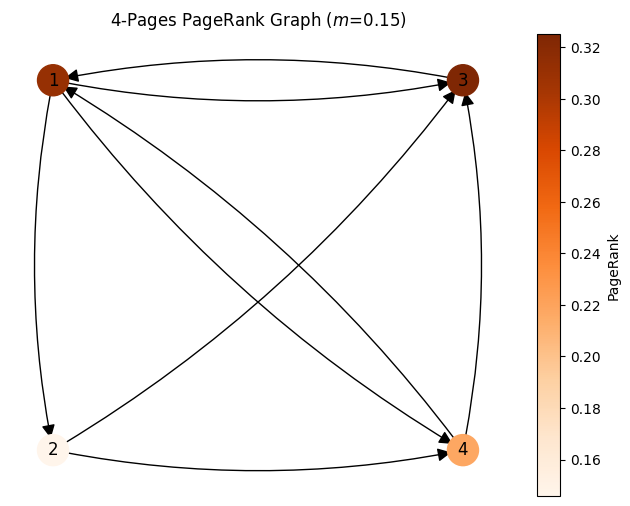

In [42]:
M,v0=compute_M_matrix(A4,0.15)
v,_,_ = pagerank_power_method_classic(M,v0)

G = nx.DiGraph()
G.add_nodes_from(range(1,5))

for i in range(4):
    for j in range(4):
        if A4[i,j] > 0:
            G.add_edge(j+1, i+1)

pos = {
    1: (0, 1),     
    3: (1, 1),     
    2: (0, 0),    
    4: (1, 0),  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))  

fig, ax = plt.subplots(figsize=(8,6))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

for (u,v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v_)],connectionstyle='arc3,rad=0.1',arrowstyle='-|>', arrowsize=20,ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank')

ax.set_title(f'4-Pages PageRank Graph ($m$={0.15})')
ax.axis('off')  
plt.show()

### 5-Pages Web Graph Plot

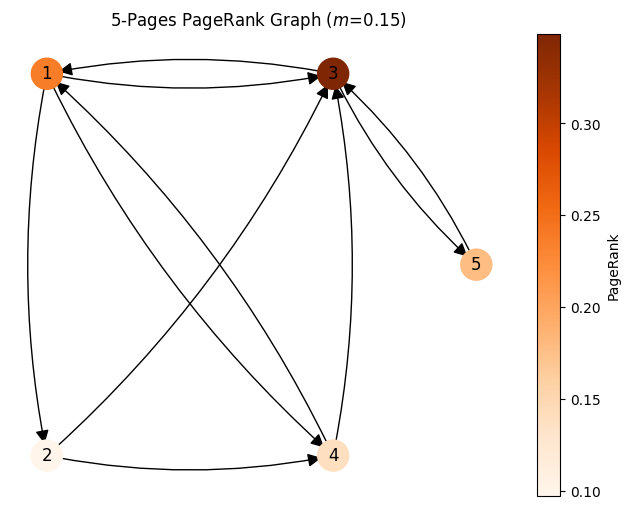

In [43]:
M,v0=compute_M_matrix(A5,0.15)
v,_,_ = pagerank_power_method_classic(M,v0)

G = nx.DiGraph()
G.add_nodes_from(range(1,5))

for i in range(5):
    for j in range(5):
        if A5[i,j] > 0:
            G.add_edge(j+1, i+1)

pos = {
    1: (0, 1),     
    3: (1, 1),     
    2: (0, 0),     
    4: (1, 0),     
    5: (1.5, 0.5)  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))  

fig, ax = plt.subplots(figsize=(8,6))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

for (u,v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v_)],connectionstyle='arc3,rad=0.1',arrowstyle='-|>', arrowsize=20,ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank')

ax.set_title(f'5-Pages PageRank Graph ($m$={0.15})')
ax.axis('off') 
plt.show()

### 5-Pages Web PageRank Sensitivity with respect to $m$

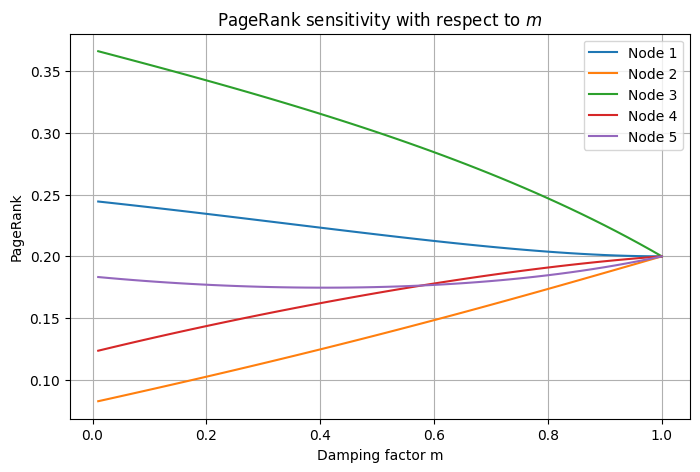

In [44]:
m_values = np.linspace(0.01, 1, 50)
pagerank_vs_m = []

for m_val in m_values:
    M,v0=compute_M_matrix(A5,m_val)
    pr,_,_ = pagerank_power_method_classic(M,v0)
    pagerank_vs_m.append(pr)

pagerank_vs_m = np.array(pagerank_vs_m)

plt.figure(figsize=(8, 5))
for i in range(5):
    plt.plot(m_values, pagerank_vs_m[:, i], label=f'Node {i+1}')

plt.xlabel('Damping factor m')
plt.ylabel('PageRank')
plt.title('PageRank sensitivity with respect to $m$')
plt.legend(loc='upper right')
plt.grid(True) 
plt.show()

### 4-Pages vs 5-Pages Web PageRank Comparison - Part 1

In [ ]:
def plot_pagerank_comparison(m):
    nodes = ['1','2','3','4','5']
    M5, v0_5 = compute_M_matrix(A5, m)   
    v5, _, _ = pagerank_power_method_classic(M5, v0_5)
    M4, v0_4 = compute_M_matrix(A4, m)   
    v4, _, _ = pagerank_power_method_classic(M4, v0_4)
    
    x = np.arange(len(nodes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.bar(x - width/2, v5, width, label='5-Pages Web')
    ax.bar(x + width/2, np.append(v4, 0), width, label='4-Pages Web')

    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_xlabel('Page')
    ax.set_ylabel('PageRank')
    ax.set_title(f'PageRank Comparison: 4-Pages Web vs 5-Pages Web ($m$={m:.2f})')
    ax.legend(loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 0.5)
    
    for i, (r1, r2) in enumerate(zip(v5, np.append(v4, 0))):
        ax.text(i - width/2, r1 + 0.01, f"{r1:.3f}", ha='center', fontsize=9)
        if r2 > 0:
            ax.text(i + width/2, r2 + 0.01, f"{r2:.3f}", ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

interact(plot_pagerank_comparison, m=FloatSlider(value=0.15, min=0.01, max=1, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, min=0.01, step=0.01), Output()), _dom_…

### 4-Pages vs 5-Pages Web PageRank Comparison - Part 2

In [46]:
def plot_pagerank_difference_relative(m=0.15):
    nodes = ['1','2','3','4']    
    M5,v0_5 = compute_M_matrix(A5, m)   
    v5,_,_ = pagerank_power_method_classic(M5, v0_5)
    M4,v0_4 = compute_M_matrix(A4, m)   
    v4,_,_ = pagerank_power_method_classic(M4, v0_4)
    v5_trim = v5[:4]
    diff_rel = ((v5_trim - v4) / v4) * 100
    
    x = np.arange(len(nodes))
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, diff_rel, width=0.3, color='green', alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_title(f'Page 5 Impact on 4-Pages Web PageRank  ($m$={m:.2f})', fontsize=13)
    ax.set_xlabel('Page')
    ax.set_ylabel('Relative Difference (%)')
    ax.grid(axis='y', linestyle='--', alpha=0.7) 

    ax.bar_label(bars, labels=[f"{val:+.1f}%" for val in diff_rel], label_type='center', fontsize=10, padding=3)

    plt.tight_layout()
    plt.show()

interact(plot_pagerank_difference_relative, m=FloatSlider(value=0.15, min=0.0, max=1, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

---
## Esercise 12
Add a sixth page that links to every page of the web in the previous exercise, but to which no other page links. Rank the pages using $\mathbf{A}$, then using $\mathbf{M}$ with $m=0.15$, and compare the results.

---

### 6-Pages Web A vs M PageRank Comparison - Part 1

In [47]:
A6 = np.array([
    [0,   0,   1/2, 1/2, 0, 1/5],
    [1/3, 0,   0,   0,   0, 1/5],
    [1/3, 1/2, 0,   1/2, 1, 1/5],
    [1/3, 1/2, 0,   0,   0, 1/5],
    [0,   0,   1/2, 0,   0, 1/5],
    [0,   0,   0,   0,   0,   0]
], dtype=float)


def plot_pagerank_comparison(m):
    M, v0 = compute_M_matrix(A6, m)
    v_m, _, _ = pagerank_power_method_classic(M, v0)
    
    n6 = A6.shape[0]
    v0_a6 = np.ones(n6)
    v0_a6 /= np.linalg.norm(v0_a6, 2)
    v_a6, _, _ = pagerank_power_method_classic(A6, v0_a6)
    
    pages = np.arange(1, 7)
    bar_width = 0.35
    plt.figure(figsize=(9, 6))
    plt.bar(pages - bar_width/2, v_a6, width=bar_width, label='A')
    plt.bar(pages + bar_width/2, v_m, width=bar_width, label=f'M ($m$={m:.2f})')
    plt.ylim(0, 0.5)
    plt.xlabel('Page')
    plt.ylabel('PageRank')
    plt.title('6-Pages web PageRank Comparison: A vs M')
    plt.xticks(pages)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout()

    for i, (r1, r2) in enumerate(zip(v_a6, v_m)):
        plt.text(i + 1 - bar_width/2, r1 + 0.01, f"{r1:.3f}", ha='center', fontsize=9)
        plt.text(i + 1 + bar_width/2, r2 + 0.01, f"{r2:.3f}", ha='center', fontsize=9)
        
    plt.show()

interact(plot_pagerank_comparison, m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 6-Pages Web A vs M PageRank Comparison - Part 2

In [48]:
def plot_pagerank_difference_relative_five(m=0.15):
    nodes = ['1', '2', '3', '4', '5']
    M, v0_M = compute_M_matrix(A6, m)
    v_M, _, _ = pagerank_power_method_classic(M, v0_M)
    n = A6.shape[0]
    v0_A6 = np.ones(n) / np.sqrt(n)
    v_A6, _, _ = pagerank_power_method_classic(A6, v0_A6)
    v_M_5 = v_M[:5]
    v_A6_5 = v_A6[:5]
    diff_rel = 100 * (v_M_5 - v_A6_5) / v_M_5

    x = np.arange(len(nodes))
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, diff_rel, width=0.3, color='darkorange', alpha=0.85)

    ax.set_xticks(x)
    ax.set_xticklabels([f'Page {i}' for i in nodes], fontsize=11)
    ax.set_title(f'Relative PageRank Difference A vs M ($m$={m:.2f})', fontsize=13, pad=15)
    ax.set_xlabel('Page', fontsize=12)
    ax.set_ylabel('Relative Difference (%)', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7) 

    ax.bar_label(bars, labels=[f"{val:+.1f}%" for val in diff_rel], label_type='center', fontsize=10, padding=3)
    plt.tight_layout()
    plt.show()

interact(plot_pagerank_difference_relative_five, m=FloatSlider(value=0.15, min=0.0, max=1, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 6-Pages Web Graph Plot

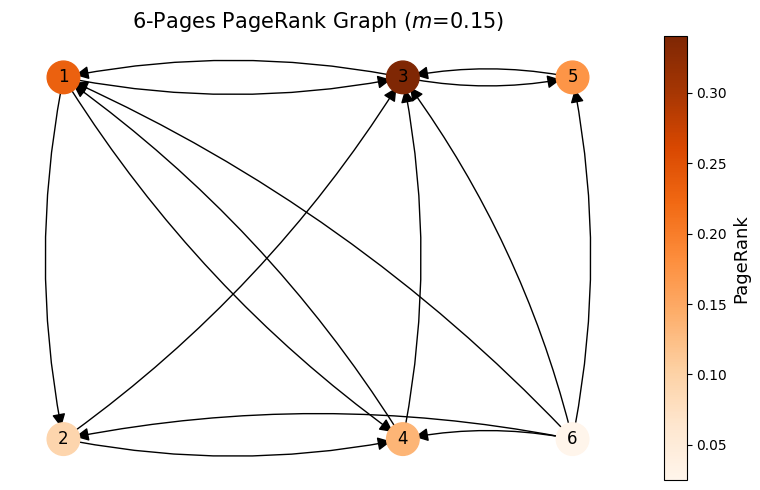

In [49]:
M, v0 = compute_M_matrix(A6, 0.15)
v, _, _ = pagerank_power_method_classic(M, v0)

G = nx.DiGraph()
G.add_nodes_from(range(1, 7)) 

for i in range(6):
    for j in range(6):
        if A6[i, j] > 0:
            G.add_edge(j+1, i+1)

pos = {
    1: (0, 1),
    3: (1, 1),
    2: (0, 0),
    4: (1, 0),
    5: (1.5, 1),
    6: (1.5, 0)  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))

fig, ax = plt.subplots(figsize=(8, 5))

nx.draw_networkx_nodes(G, pos, node_size=550, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12)

for (u, v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v_)], connectionstyle='arc3,rad=0.1',arrowstyle='-|>', arrowsize=20, ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank', fontsize=13)

ax.set_title(f'6-Pages PageRank Graph ($m$={0.15})', fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()

---
## Hollins Dataset 
---
### Dataset Import 

In [50]:
df = pd.read_csv("hollins.dat", sep=r"\s+", header=None)
N = int(df.iloc[0, 0])

urls = df.iloc[1:N+1].set_index(0)[1]
links = df.iloc[N+1:, [0, 1]].astype(int)
links.columns = ["source", "target"]

outdeg = links["source"].value_counts()
keep = outdeg.index.sort_values().to_numpy()
id2idx = {id_: i for i, id_ in enumerate(keep)}

links = links[links["source"].isin(keep) & links["target"].isin(keep)]
row = links["target"].map(id2idx)
col = links["source"].map(id2idx)
data = 1.0 / outdeg[links["source"]].to_numpy()

A = csr_matrix((data, (row, col)), shape=(len(keep), len(keep)))

url_map_clean = pd.DataFrame({
    "matrix_index": range(len(keep)),
    "url": urls.loc[keep].to_numpy()
})

### Top 10 Pages PageRank Computation

In [51]:
def plot_top10_pagerank(A, url_map_clean, m=0.15, n=10):
    M, v0 = compute_M_matrix(A, m)
    v, _, _ = pagerank_power_method_classic(M, v0)
    idx_top = np.argsort(v)[-n:][::-1]
    ranks_top = v[idx_top]
    urls_top = url_map_clean.iloc[idx_top]["url"].values

    plt.figure(figsize=(9, 6))
    plt.bar(range(n), ranks_top)
    plt.xticks(range(n), urls_top, rotation=45, ha='right')
    plt.ylabel("PageRank")
    plt.title(f"Top {n} URLs by PageRank ($m$={m:.2f})")
    for i, val in enumerate(ranks_top):
        plt.text(i, val + 0.01 * ranks_top.max(), f"{val:.3f}", ha="center")
    plt.tight_layout()
    plt.show()

interact(lambda m: plot_top10_pagerank(A, url_map_clean, m, n=10),m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description="m"));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### PageRank Scatter - All Pages

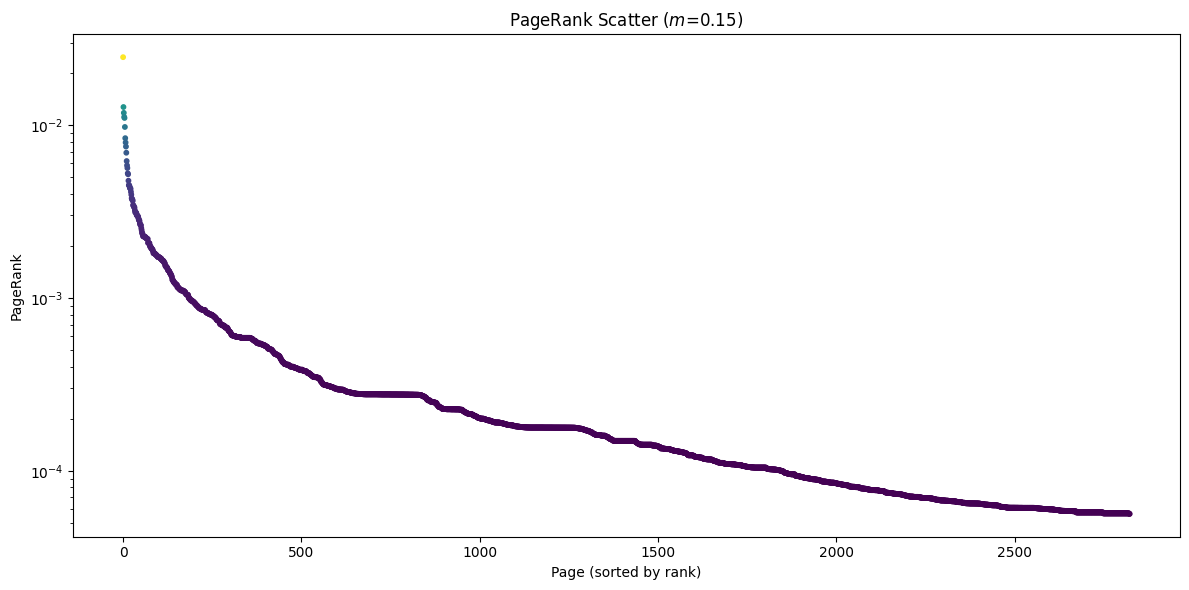

In [52]:
def plot_rank_scatter_all(A, m=0.15):
    M, v0 = compute_M_matrix(A, m)
    v, _, _ = pagerank_power_method_classic(M, v0)
    ranks_sorted = np.sort(v)[::-1]

    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(ranks_sorted)), ranks_sorted, s=10, c=ranks_sorted, cmap='viridis')
    plt.xlabel('Page (sorted by rank)')
    plt.ylabel('PageRank')
    plt.title(f'PageRank Scatter ($m$={m:.2f})')
    plt.yscale('log')  
    plt.tight_layout()
    plt.show()

plot_rank_scatter_all(A, m=0.15)

### PageRank Distribution and CDF

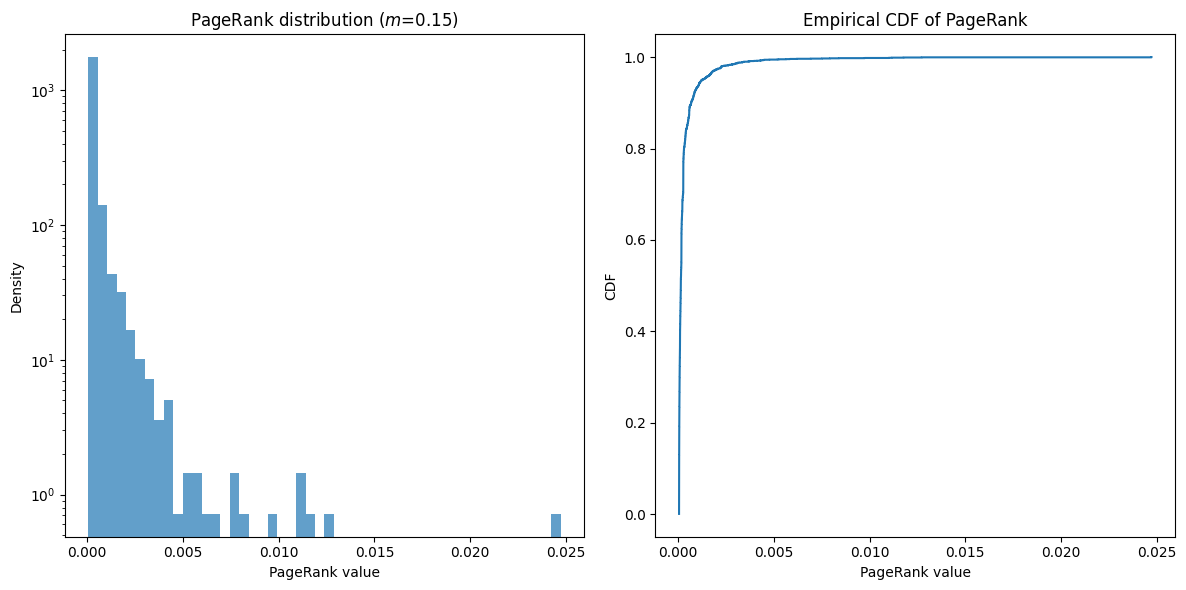

In [53]:
def plot_pagerank_hist_and_cdf(A, m=0.15, bins=50):
    M, v0 = compute_M_matrix(A, m)
    v, _, _ = pagerank_power_method_classic(M, v0)
    v = np.asarray(v).reshape(-1)


    v_sorted = np.sort(v)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].hist(v, bins=bins, density=True, alpha=0.7)
    ax[0].set_xlabel("PageRank value")
    ax[0].set_ylabel("Density")
    ax[0].set_title(f"PageRank distribution ($m$={m:.2f})")
    ax[0].set_yscale("log")  

    N = len(v_sorted)
    cdf = np.arange(1, N+1) / N
    ax[1].plot(v_sorted, cdf, drawstyle="steps-post")
    ax[1].set_xlabel("PageRank value")
    ax[1].set_ylabel("CDF")
    ax[1].set_title("Empirical CDF of PageRank")

    plt.tight_layout()
    plt.show()

plot_pagerank_hist_and_cdf(A, m=0.15, bins=50)

### PageRank Concentration

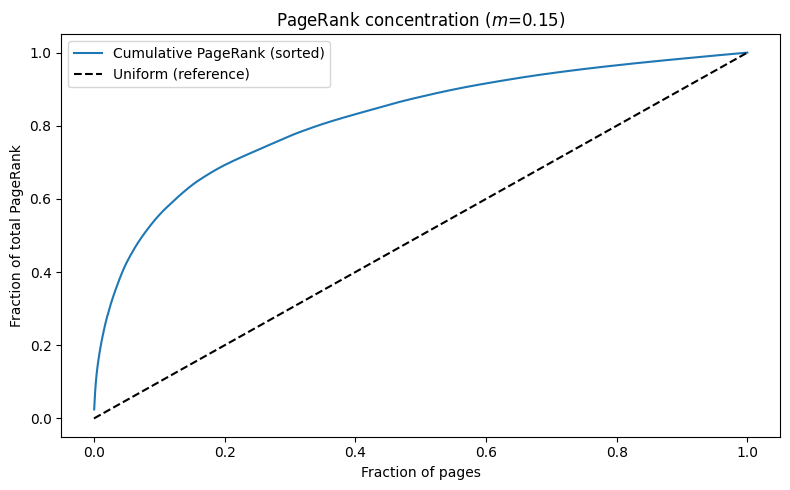

In [54]:
def plot_pagerank_lorenz(A, m=0.15):
    M, v0 = compute_M_matrix(A, m)
    v, _, _ = pagerank_power_method_classic(M, v0)
    v = np.asarray(v).reshape(-1)

    v_sorted = np.sort(v)[::-1]        
    cum_rank = np.cumsum(v_sorted)     
    cum_rank /= cum_rank[-1]           

    N = len(v)
    x = np.arange(1, N+1) / N          

    plt.figure(figsize=(8, 5))
    plt.plot(x, cum_rank, label="Cumulative PageRank (sorted)")
    plt.plot([0, 1], [0, 1], "k--", label="Uniform (reference)")
    plt.xlabel("Fraction of pages")
    plt.ylabel("Fraction of total PageRank")
    plt.title(f"PageRank concentration ($m$={m:.2f})")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pagerank_lorenz(A, m=0.15)

### Functions Definitions

In [55]:

def get_ground_truth(M, tol=1e-16, max_iter=5000):
    n = M.shape[0]
    v = np.ones(n) / n
    
    # [FIX] Forziamo v a essere un array 1D piatto fin dall'inizio
    v = np.asarray(v).reshape(-1)
    
    for _ in range(max_iter):
        v_next = M @ v
        
        # [FIX] Appiattiamo il risultato.
        # Se M è sparsa, il prodotto M @ v crea una colonna (N,1).
        # Noi vogliamo un array piatto (N,) per poter fare la sottrazione.
        v_next = np.asarray(v_next).reshape(-1)
        
        # Uso np.sum(np.abs(...)) che è l'equivalente sicuro di norm(..., 1)
        if np.sum(np.abs(v_next - v)) < tol:
            return v_next
            
        v = v_next
        
    return v

def calculate_c(M):
    # [FIX] Gestione Matrici Sparse
    # Se M è una matrice sparsa (scipy), np.min non funziona come sui normali array.
    # La convertiamo in densa solo per questo calcolo (se non è gigante).
    if hasattr(M, "toarray"):
        M_dense = M.toarray()
    else:
        M_dense = M
        
    # Calcolo del minimo per ogni colonna (axis=0)
    min_val_cols = np.min(M_dense, axis=0)
    
    # Formula dell'esercizio
    c = np.max(np.abs(1 - 2 * min_val_cols))
    return c

def run_simulation(M, x0, q_true, steps=60):
    # [FIX] Appiattiamo tutti gli input per evitare errori di forma
    v = np.asarray(x0.copy()).reshape(-1)
    q_true = np.asarray(q_true).reshape(-1)
    
    errors = []
    ratios = []
    
    # Calcolo errore iniziale
    prev_error = np.sum(np.abs(v - q_true))
    errors.append(prev_error)
    ratios.append(np.nan)
    
    for k in range(1, steps + 1):
        v = M @ v
        
        # [FIX] Appiattiamo il risultato post-moltiplicazione
        v = np.asarray(v).reshape(-1)
        
        # Calcolo errore corrente (Norma L1)
        curr_error = np.sum(np.abs(v - q_true))
        
        if prev_error > 1e-20:
            ratio = curr_error / prev_error
        else:
            ratio = 0.0
            
        errors.append(curr_error)
        ratios.append(ratio)
        
        prev_error = curr_error
        
    return errors, ratios

###Computation of Errors Norms and Ratios 

In [56]:

m = 0.15
M, _ = compute_M_matrix(A5, m) 
n = A5.shape[0]
q_true = get_ground_truth(M)

x0 = np.ones(n) / n
errors, ratios = run_simulation(M, x0, q_true, steps=55)

## Visualizzazione Tabella (k = 1, 5, 10, 50)
target_k = [1, 5, 10, 50]
results = {
    "k": target_k,
    "L1 Error": [errors[k] for k in target_k],
    "Ratio": [ratios[k] for k in target_k]
}

df = pd.DataFrame(results)
print(df.to_string(index=False, float_format="%.6e"))

 k     L1 Error        Ratio
 1 2.218875e-01 5.963605e-01
 5 3.408111e-02 5.719266e-01
10 2.799481e-03 6.143626e-01
50 7.877921e-12 6.112511e-01


###Graphs of Errors and Convergence Rates

In [57]:

def plot_interactive_analysis(start_strategy):
    
    if start_strategy == 'Uniform (1/n)':
        x0 = np.ones(n) / n
    elif start_strategy == 'Page 3 (Dominant)':
        x0 = np.zeros(n); x0[2] = 1.0 
    elif start_strategy == 'Page 1 (Weak)':
        x0 = np.zeros(n); x0[0] = 1.0
    elif start_strategy == 'Random':
        np.random.seed(42)
        x0 = np.random.rand(n); x0 /= x0.sum()
    
    
    errors, ratios = run_simulation(M, x0, q_true, steps=60)
    
    lambda_2_est = ratios[-1]
    c_val = calculate_c(M)

    k_vals = range(len(errors))

    plt.figure(figsize=(10, 5))
    plt.plot(k_vals, errors, 'o-', markersize=4, label=f'Start: {start_strategy}')
    plt.yscale('log')
    plt.title('Decadimento Errore (Scala Log)')
    plt.xlabel('Iterazione k')
    plt.ylabel('Errore')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig('grafico_errore.png', dpi=300)
    plt.show()

    
    plt.figure(figsize=(10, 5))
    plt.plot(k_vals[1:], ratios[1:], 'o-', color='orange', markersize=4, label='Rapporto Empirico')
    plt.axhline(y=lambda_2_est, color='green', linestyle='--', label=f'Est. |λ2| ≈ {lambda_2_est:.3f}')
    plt.axhline(y=c_val, color='red', linestyle=':', label=f'Bound c = {c_val:.3f}')
    
    plt.title('Velocità di Convergenza')
    plt.xlabel('Iterazione k')
    plt.ylim(0.4, 1.0)
    plt.legend()
    plt.grid(True)
    plt.savefig('grafico_velocità.png', dpi=300)
    plt.show() 

print("Seleziona il tipo di partenza per vedere l'effetto sulla convergenza:")
interact(plot_interactive_analysis, 
         start_strategy=widgets.Dropdown(
             options=['Uniform (1/n)', 'Page 3 (Dominant)', 'Page 1 (Weak)', 'Random'],
             value='Uniform (1/n)',
             description='x0:',
         ));

Seleziona il tipo di partenza per vedere l'effetto sulla convergenza:


interactive(children=(Dropdown(description='x0:', options=('Uniform (1/n)', 'Page 3 (Dominant)', 'Page 1 (Weak…

###Comparison with Theoretical Contraction Coefficient and Subdominant Eigenvalue

Generazione grafico di confronto teorico...


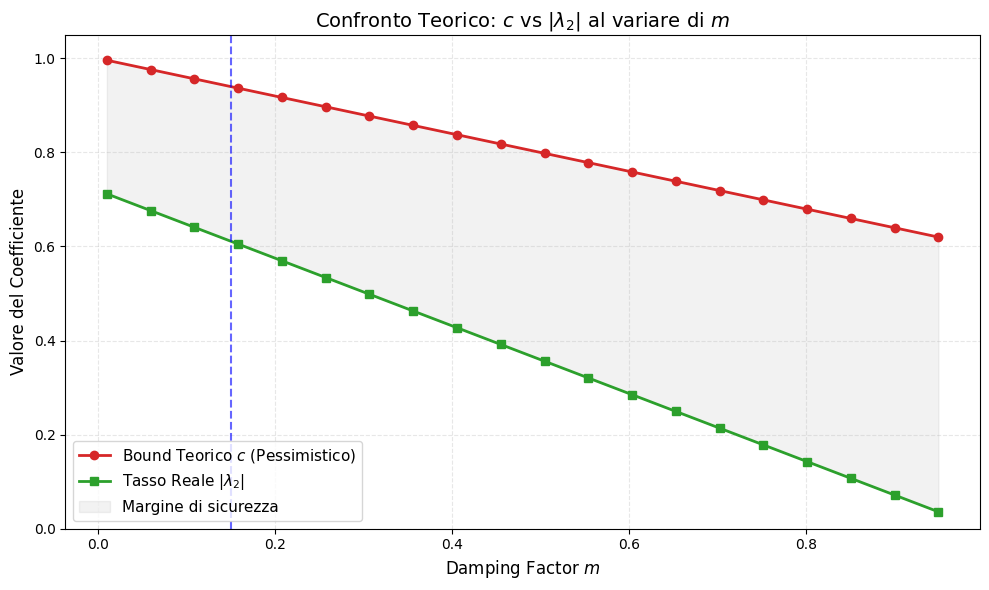

In [58]:

def plot_theoretical_sensitivity(A_matrix):
    m_values = np.linspace(0.01, 0.95, 20)
    c_vals = []
    lambda2_vals = []
    
    
    for m_val in m_values:
        M_temp, _ = compute_M_matrix(A_matrix, m_val)
        
        
        c_vals.append(calculate_c(M_temp))
        
        
        vals, _ = np.linalg.eig(M_temp)
        vals = np.sort(np.abs(vals))[::-1]
        lambda2_vals.append(vals[1])

    
    plt.figure(figsize=(10, 6))
    
   
    plt.plot(m_values, c_vals, 'o-', color='#d62728', linewidth=2, label=r'Bound Teorico $c$ (Pessimistico)')
    plt.plot(m_values, lambda2_vals, 's-', color='#2ca02c', linewidth=2, label=r'Tasso Reale $|\lambda_2|$')
    
    
    plt.fill_between(m_values, c_vals, lambda2_vals, color='gray', alpha=0.1, label='Margine di sicurezza')
    
    
    plt.axvline(0.15, color='blue', linestyle='--', alpha=0.6)
   
  
    plt.title(r'Confronto Teorico: $c$ vs $|\lambda_2|$ al variare di $m$', fontsize=14)
    plt.xlabel('Damping Factor $m$', fontsize=12)
    plt.ylabel('Valore del Coefficiente', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=11, loc='lower left')
    
    plt.tight_layout()
    plt.show()

print("Generazione grafico di confronto teorico...")
plot_theoretical_sensitivity(A5)

###giga database


Teorico (1-m): 0.8500
 k  L1 Error    Ratio
 1  0.878880 0.878880
 5  0.655576 0.936957
20  0.269150 0.943795
20  0.269150 0.943795
30  0.151351 0.944194
40  0.085288 0.944289
50  0.048084 0.944312


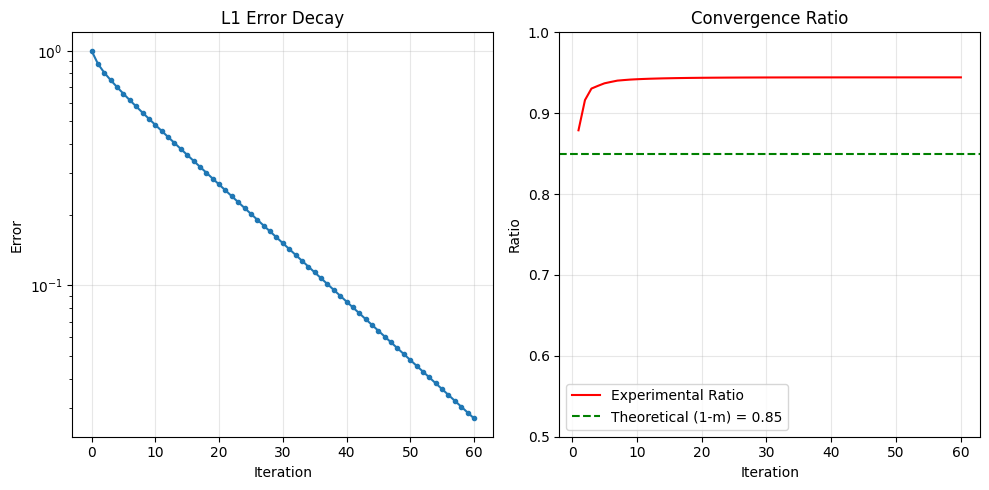

In [59]:
m= 0.15
steps=60
M, _ = compute_M_matrix(A, m)
q_true = get_ground_truth(M)
n = M.shape[0]
x0 = np.ones(n) / n
errors, ratios = run_simulation(M, x0, q_true, steps=steps)

target_k=[1, 5, 20, 20, 30, 40, 50]
results = {
    "k": target_k,
    "L1 Error": [errors[k] for k in target_k],
    "Ratio": [ratios[k] for k in target_k]
}

print(f"\nTeorico (1-m): {1 - m:.4f}")
print(pd.DataFrame(results).to_string(index=False, float_format="%.6f"))

# 5. Grafici
plt.figure(figsize=(10, 5))

# Plot Errore
plt.subplot(1, 2, 1)
plt.plot(errors, 'o-', markersize=3)
plt.yscale('log')
plt.title("L1 Error Decay")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.grid(True, alpha=0.3)

# Plot Rapporto di Convergenza
plt.subplot(1, 2, 2)
plt.plot(ratios, 'r-', label='Experimental Ratio')
plt.axhline(y=1-m, color='g', linestyle='--', label=f'Theoretical (1-m) = {1-m:.2f}')
plt.title("Convergence Ratio")
plt.xlabel("Iteration")
plt.ylabel("Ratio")
plt.legend()
plt.ylim(0.5, 1.0)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


###miglioramento dei dampling nodes

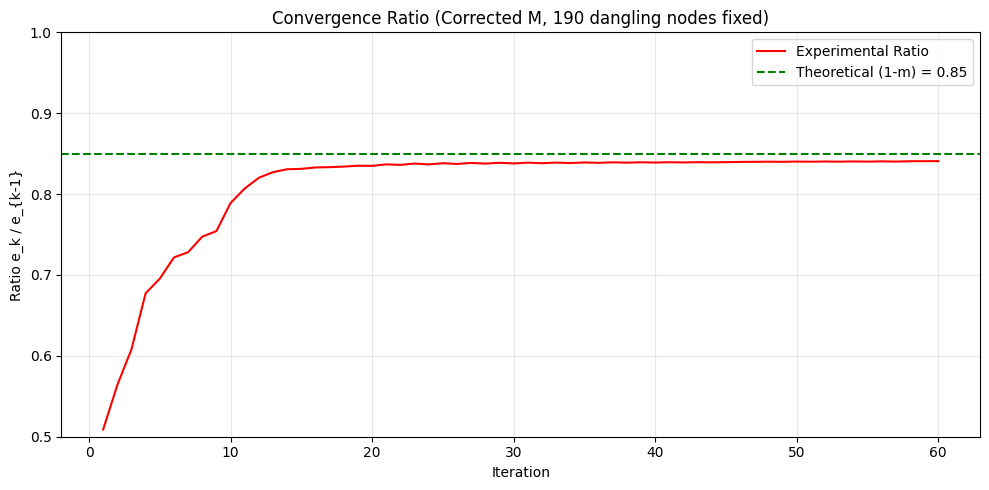

In [60]:
#set up
m = 0.15
steps = 60
n = A.shape[0]
#compute M withc Patch for dampling nodes
S = np.ones((n, n)) / n
M_nuova, _ =compute_M_matrix(A, m)

##Convertiamo in denso per poterla ispezionare/modificare facilmente
if hasattr(M_nuova, "toarray"):
    M_dense = M_nuova.toarray()
else:
    M_dense = M_nuova

#correction of dandling nodes 
col_sums = M_dense.sum(axis=0)
dangling_nodes = np.where(col_sums <= m + 0.01 )[0]

massing_mass = (1-m)/n 
for j in dangling_nodes:
    M_dense[:, j] += massing_mass

final_sums = M_dense.sum(axis=0)
M_dense /= final_sums


q_true = get_ground_truth(M_dense)
x0 = np.ones(n) / n
errors, ratios = run_simulation(M_dense, x0, q_true, steps=steps)

plt.figure(figsize=(10, 5))

plt.plot(ratios, 'r-', label='Experimental Ratio')
plt.axhline(y=1-m, color='g', linestyle='--', label=f'Theoretical (1-m) = {1-m:.2f}')
plt.title(f"Convergence Ratio (Corrected M, {len(dangling_nodes)} dangling nodes fixed)")
plt.xlabel("Iteration")
plt.ylabel("Ratio e_k / e_{k-1}")
plt.legend()
plt.ylim(0.5, 1.0)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


